# Memorization vs Generalization

Neuronale Netze gehören mittlerweile zum Standard-Repertoire des Maschienllen Lernens. Wir erwarten von ihnen, dass sie "einfach lernen". Doch was genau ist mit diesem Begiff eigentlich gemeint? 

## Lernen

Der Begriff _lernen_ lässt in diesem Zusammenhang zwei Interpretationen zu.
- "Learning by memorization": Das Modell lernt die Samples und kann die gelernten Daten später korrekt zuordnen. Ungesehene Daten werden nicht korrekt klassifiziert. 
- "Generalization": Das Modell extrahiert aus den Samples Regeln, die für eine Zuordnung von Bedeutung sind. Durch Anwendung dieser allgemeinen Regeln auf ungesehene Daten können auch diese korrekt klassifiziert werden.

[Quelle?] 

In der Regel erwartet man bei dem Begriff _lernen_ zweiteres. Das Modell soll mit den Trainingsdaten lernen, zusammenhänge und Regeln zu erkennen und auf neue, ungesehene Daten anwenden können. 

In diesem Notebook werden wir uns jedoch mit dem ersteren beschäftigen – der Memorization. Auch hierbei leisten DNN durchaus erstaunliches und ein Verständnis dieser Thematik hilft dabei Netze zu entwickeln die besser generalisieren können. 

## Testumgebung

Wir verwenden in diesem Notebook die Folgende kleine Testumgebung um vergleichbare CNNs mit veschiedenen Parametern und Trainingsdaten zu erstellen und auszwerten. Die Erstellung der netzte erfolgt mit Keras, da es eine einfache und nachvollziehbare API bietet mit deren Hilfe sehr schnell und effizient verschiedene Netze erstellt werden können. Als Backend zur eigentlichen Ausführung fungiert Tensorflow, daher ist auch eine schnelle Ausführung auf einer GPU möglich. 
Mithilfe der GPU werden die Netze erheblich schneller trainiert, daher wird die Verwendung empfohlen.

### Konfigurationsparameter

- FORCE_BUILD_MODELS: 

In [2]:
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import SGD
import random, os, json

FORCE_BUILD_MODELS = True

Using TensorFlow backend.


Wir verwenden das CIFAR10 Dataset, welches aus 50000 niedrig aufgelösten Bildern besteht, welche 10 verschiedenen Klassen zugeordnet sind. 
Zur Veranschaulichung der Daten wird eine zufällige Auswahl angezeigt.

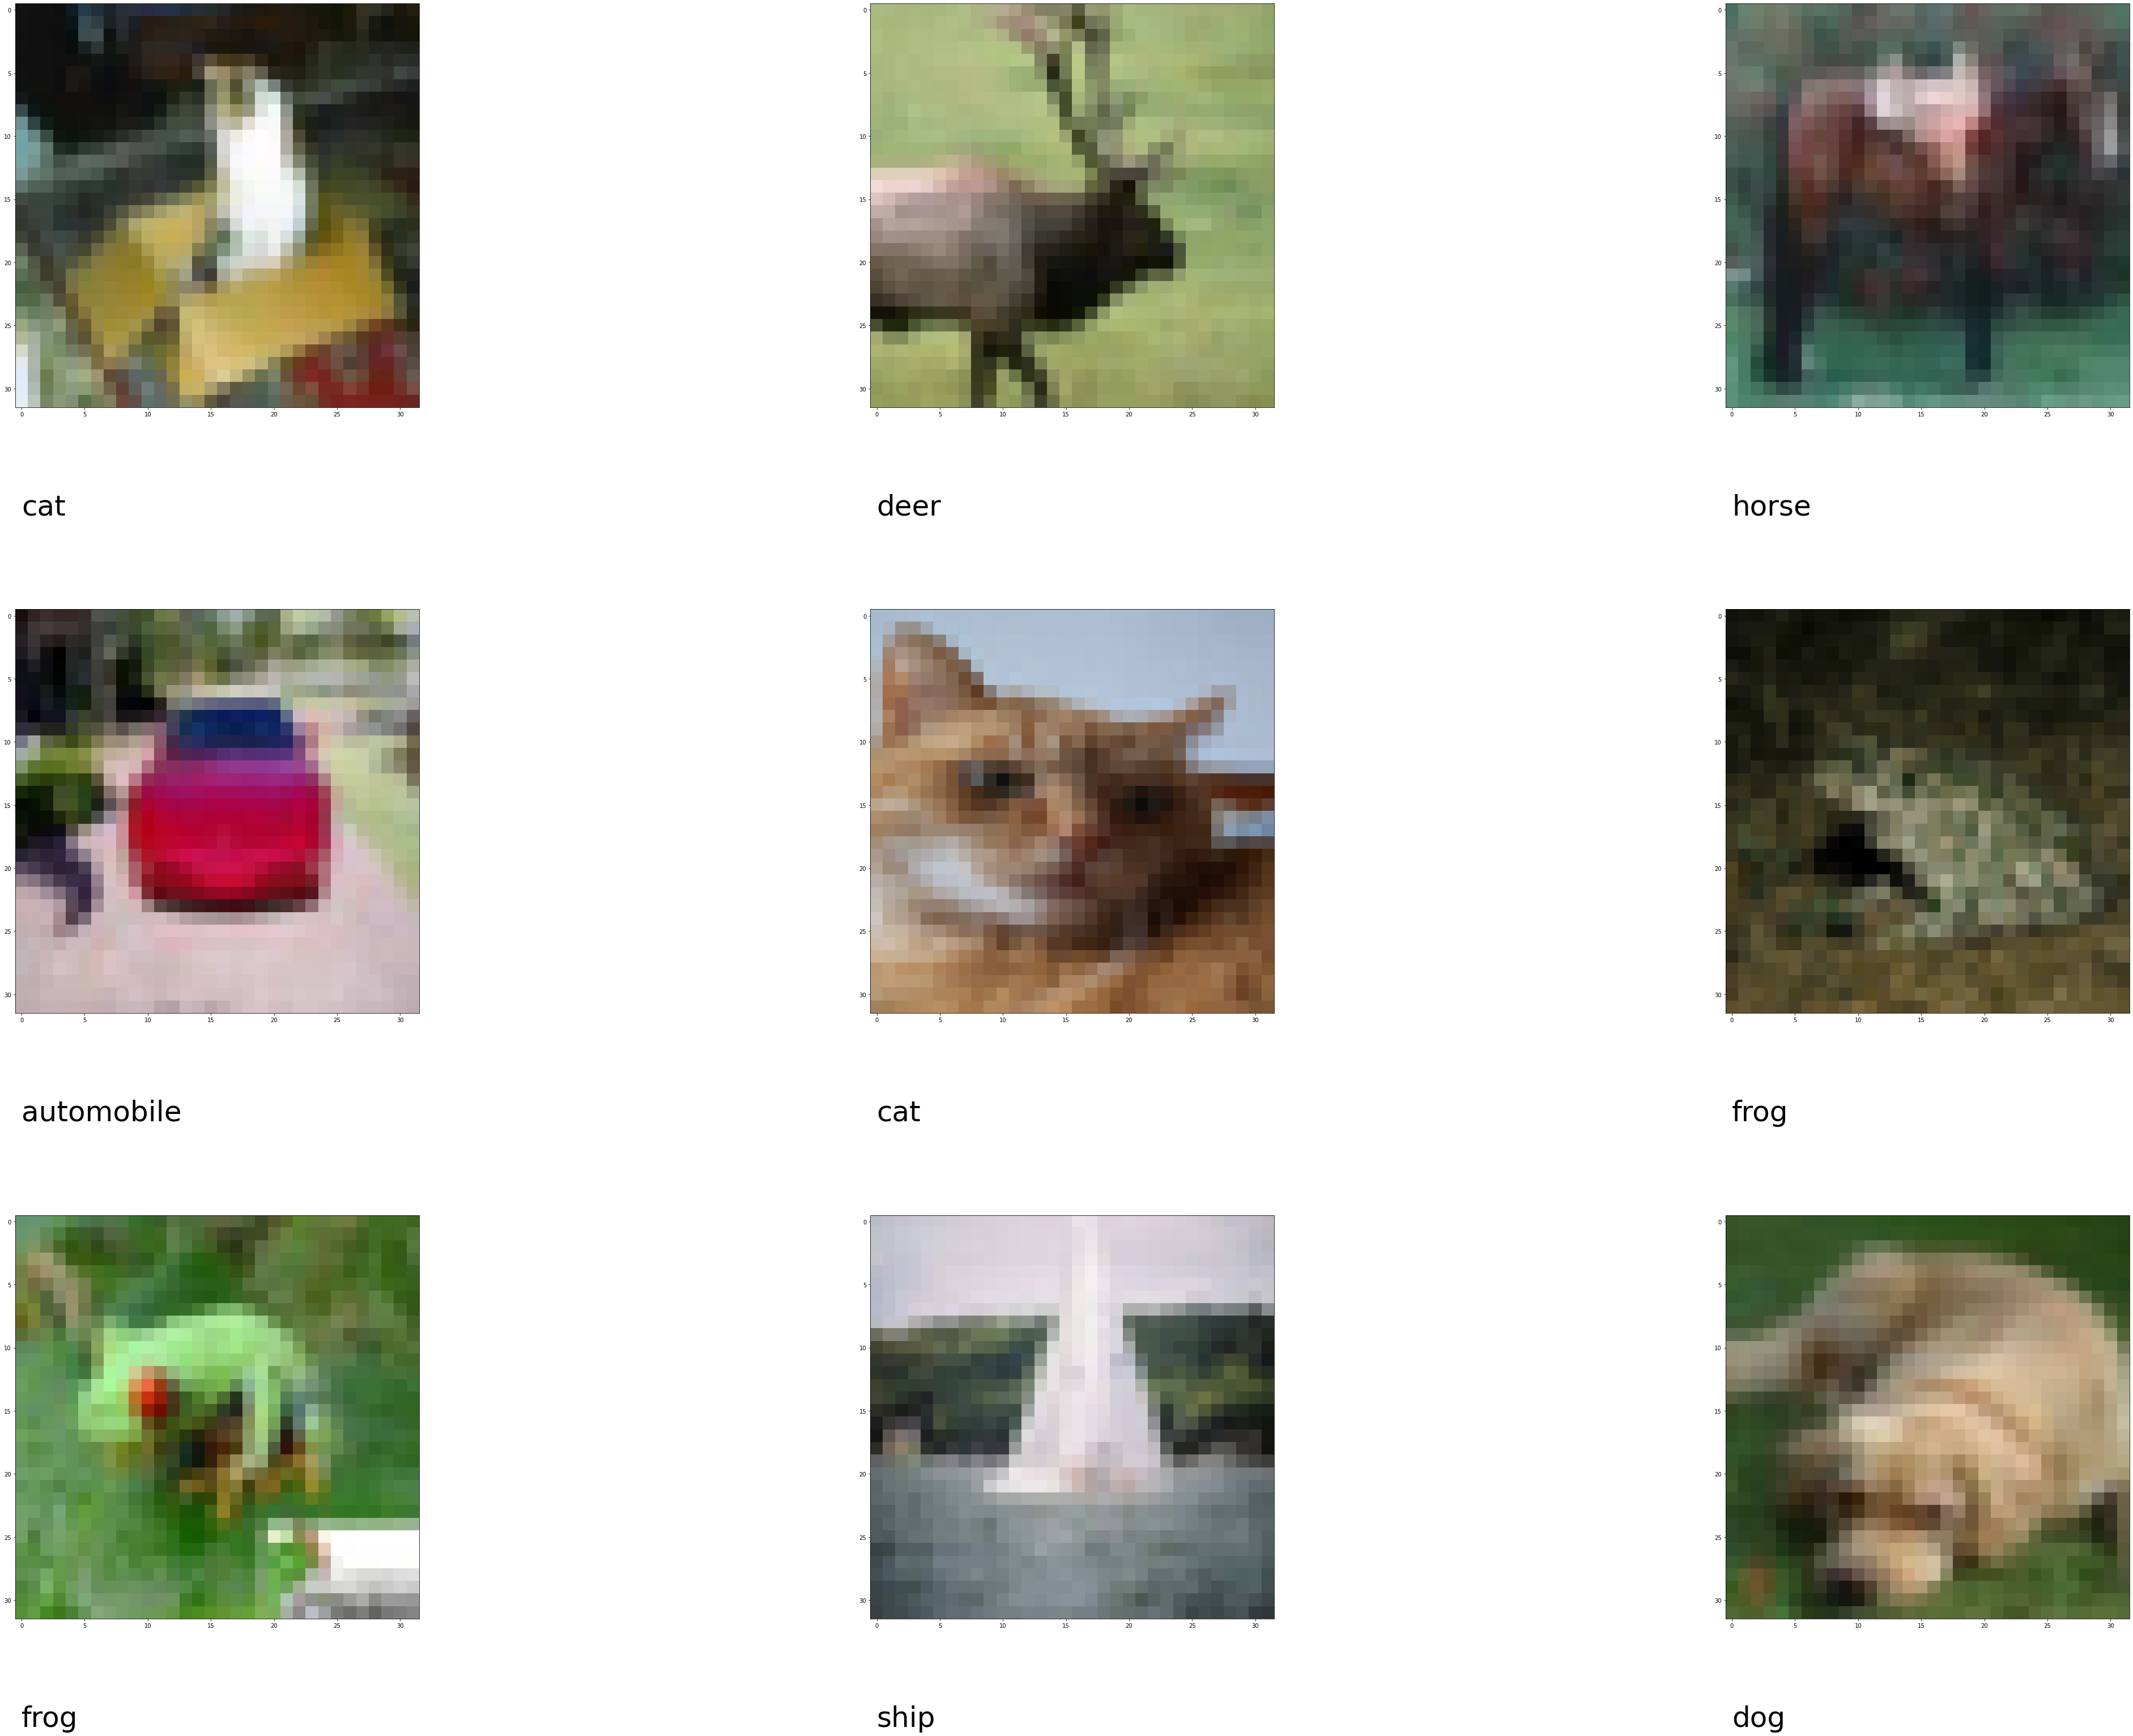

In [3]:
(trainX, trainY), (testX, testY) = cifar10.load_data()
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

for i in range(9):
    nr = random.randint(1, len(trainX))
    pyplot.subplot(330 + 1 + i, ymargin=20)
    pyplot.imshow(trainX[nr])
    pyplot.text(0, 40, class_names[trainY[nr][0]], fontsize=50)

#pyplot.tight_layout()
pyplot.subplots_adjust(left=0.1, right=10.0, top=10.0, bottom=0.1, hspace=0.5)
pyplot.show()



Mehr Erklärung

In [4]:

#trainX = trainX[:10000,:,:,:]
#testX = testX[:5000,:,:,:]

#trainY = trainY[:10000]
#testY = testY[:5000]

trainY_shuffle = list(trainY)
random.shuffle(trainY_shuffle)


Mehr Erklärung

In [5]:
trainY = to_categorical(trainY)
testY = to_categorical(testY)
trainY_shuffle = to_categorical(trainY_shuffle)

trainX = trainX.astype('float32')
testX = testX.astype('float32')

trainX = trainX / 255.0
testX = testX / 255.0

Mehr Erklärung

(Beschreiben was hier passiert)

In [6]:
def create_model(conv1_count, conv2_count=0, conv3_count=0, add_dropout=False, dense_count=10):
    ''' Parameter conv1 etc umbenennen'''
    model = Sequential()
    model.add(Conv2D(conv1_count, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(conv1_count, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    if add_dropout:
        model.add(Dropout(add_dropout))
    model.add(MaxPooling2D((2, 2)))
    if conv2_count != 0:
        model.add(Conv2D(conv2_count, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv2_count, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        if add_dropout:
            model.add(Dropout(add_dropout))
        model.add(MaxPooling2D((2, 2)))
    if conv3_count != 0:
        model.add(Conv2D(conv3_count, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(Conv2D(conv3_count, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        if add_dropout:
            model.add(Dropout(add_dropout))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_count, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def plot_summary(history):
    # Plot the loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history['loss'], color='blue', label='train')
    pyplot.plot(history['val_loss'], color='red', label='test')
    pyplot.legend(loc='lower right')
    # Plot the accuracy
    pyplot.subplot(212)
    pyplot.title('Accuracy')
    pyplot.plot(history['acc'], color='blue', label='train')
    pyplot.plot(history['val_acc'], color='red', label='test')
    pyplot.legend(loc='lower right')

    
def create_or_load_model(name, model_params, train_func):
    model_path = 'models/{}.model'.format(name)
    history_path = 'models/{}_history.json'.format(name)
    if os.path.isfile(model_path) and not FORCE_BUILD_MODELS:
        
        model = load_model(model_path)
        with open(history_path) as file:
            history = json.load(file)
    else:
        ''' Mehr Erklärungen hier'''
        model = create_model(**model_params)
        history = train_func(model)
        model.save(model_path)
        with open(history_path, 'w') as file:
            json.dump(history.history, file)
            history = history.history
    return (model, history)

Mehr Erklärung

## Memoriazation

Wir trainieren ein Modell mit 3 Schichten welches als Referenz für die CIFAR10-Challange dient.

Aufruf von create_or_load_model erklären

In [10]:
normal_params = dict(conv1_count=32, conv2_count=64, conv3_count=128, add_dropout=False, dense_count=512)
model_normal, history_normal = create_or_load_model('normal', normal_params, lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
12352/50000 [======>.......................] - ETA: 7s - loss: 2.0572 - accuracy: 0.2556

KeyboardInterrupt: 

In [8]:
print("Parameter: {:,}".format(model_normal.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_normal['acc'][-1], history_normal['val_acc'][-1]))
plot_summary(history_normal)

NameError: name 'model_normal' is not defined

(Loss besser verstehen und erklären. Warum 2???

Dieses Netz ist das gleiche wie oben, nur dass dieses mal die randomisierten Labels als Y-Daten genutzt werden.

In [11]:
model_random, history_random = create_or_load_model('random', normal_params, lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64,  validation_data=(testX, testY)))


Train on 50000 samples, validate on 10000 samples
Epoch 1/100
14400/50000 [=======>......................] - ETA: 5s - loss: 2.3223 - accuracy: 0.0968

KeyboardInterrupt: 

Parameter: 1,341,226
Final Accuracy: 0.97646; Final Validation Accuracy: 0.0967


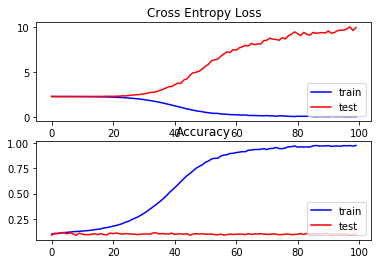

In [9]:
print("Parameter: {:,}".format(model_random.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_random['acc'][-1], history_random['val_acc'][-1]))
plot_summary(history_random)

## Vergleiche

loss vergleichen?

Im folgenden Diagramm wird die Accuracy der Validationsets über 100 Episoden dargestellt.

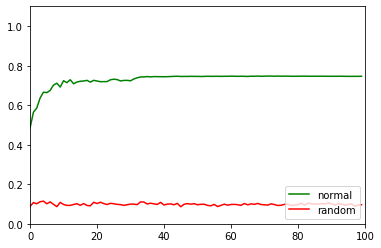

In [10]:
pyplot.plot(history_normal['val_acc'], color='green', label='normal')
pyplot.plot(history_random['val_acc'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Das Referenz-Modell erreicht eine zufriedenstellende Leistung von knapp 75%.

Wenig überraschend ist die Performance des randomisierten Modells bei knapp 10%, was bei 10 Klassen genau der zu erwartenten Wahrscheinlichkeit einer rein zufälligen Klassenzuordnung entspricht. Das Modell hat aus den Trainingsdaten also keine Regeln zur Generalisierung ableiten können.

Das folgende Diagramm vergleicht die Accuracy der Trainingsdaten der biden Varianten miteinander.

In [ ]:
pyplot.plot(history_normal['acc'], color='green', label='normal')
pyplot.plot(history_random['acc'], color='red', label='random')
pyplot.axis([0, 100, 0, 1.1])
pyplot.legend(loc='lower right')
pyplot.show()

Hier ergibt sich ein interessanteres Bild. Beide Modelle sind in der Lage, die Klassifikation der Daten nahezu vollständig zu erinnern. Auch das Modell, welches die Daten mit randomisierten Klassen zum Training bekommen hat, ist nach einer langsamen Anfangsphase relativ schnell in der Lage die Daten zu erinnern. 
Der Großteil des "auswendig lernens" passiert innerhalb von nur 25 Episoden, eine ähnlich lange Zeit benötigt auch das Referent-Modell, nur dass hier die Erinnerung schon nach 25 Episoden fast abgeschlossen ist. 


(Warum beginnt das erinnern erst später?)

## Einfluss der Kapazität

### Kapazität 

Jedes mathmatische Modell bestetht aus einer bestimmten Anzahl an Parametern. Diese beschränken die Möglichkeit eines Modells, sich einer beliebigen Funktion anzunähern. (Kapazität und fähigkeit von Netzen Daten zu speichern, paper wiederfinden)

Die Kapazität eines Neuronalen Netzwerkes bestimmt sich durch die Anzahl und Größe der verstecken Schichten. Als Richtwert, lässt sich die Anzahl der Parameter nutzen. 
Eine exakte Angabe der Kapazität ist jedoch nur schwer möglich. \cite{Deep Learning}



In [12]:
small_params = dict(conv1_count=3, add_dropout=False, dense_count=128)
model_small, history_small = create_or_load_model('small', small_params, lambda model: model.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY)))



Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 4s 81us/step - loss: 2.2402 - accuracy: 0.1606 - val_loss: 2.0346 - val_accuracy: 0.2664
Epoch 2/200
50000/50000 [==============================] - 4s 75us/step - loss: 1.8355 - accuracy: 0.3382 - val_loss: 1.7102 - val_accuracy: 0.3878
Epoch 3/200
50000/50000 [==============================] - 4s 75us/step - loss: 1.6536 - accuracy: 0.4045 - val_loss: 1.6008 - val_accuracy: 0.4179
Epoch 4/200
50000/50000 [==============================] - 4s 75us/step - loss: 1.5793 - accuracy: 0.4350 - val_loss: 1.5625 - val_accuracy: 0.4370
Epoch 5/200
50000/50000 [==============================] - 4s 75us/step - loss: 1.5285 - accuracy: 0.4538 - val_loss: 1.5210 - val_accuracy: 0.4551
Epoch 6/200
50000/50000 [==============================] - 4s 75us/step - loss: 1.4947 - accuracy: 0.4675 - val_loss: 1.4879 - val_accuracy: 0.4710
Epoch 7/200
50000/50000 [==============================] - 4s 

KeyboardInterrupt: 

In [ ]:
print("Parameter: {:,}".format(model_small.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_small['acc'][-1], history_small['val_acc'][-1]))
plot_summary(history_small)

(Interpreation...)

(Schwerer zu Erinnern, geht aber trotzdem, nicht so einfach anzugeben alles)

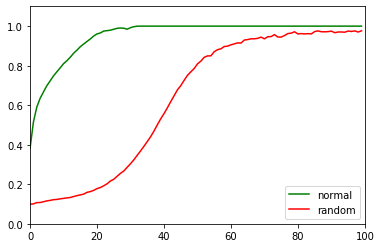

In [11]:
## Overfitting

Hier ergibt sich ein interessanteres Bild. Beide Modelle sind in der Lage, die Klassifikation der Daten nahezu vollständig zu erinnern. Auch das Modell, welches die Daten mit randomisierten Klassen zum Training bekommen hat, ist nach einer langsamen Anfangsphase relativ schnell in der Lage die Daten zu erinnern. 
Der Großteil des "auswendig lernens" passiert innerhalb von nur 25 Episoden, eine ähnlich lange Zeit benötigt auch das Referent-Modell, nur dass hier die Erinnerung schon nach 25 Episoden fast abgeschlossen ist. 


(Warum beginnt das erinnern erst später?)

## Einfluss der Kapazität

### Kapazität 

Jedes mathmatische Modell bestetht aus einer bestimmten Anzahl an Parametern. Diese beschränken die Möglichkeit eines Modells, sich einer beliebigen Funktion anzunähern. (Kapazität und fähigkeit von Netzen Daten zu speichern, paper wiederfinden)

Die Kapazität eines Neuronalen Netzwerkes bestimmt sich durch die Anzahl und Größe der verstecken Schichten. Als Richtwert, lässt sich die Anzahl der Parameter nutzen. 
Eine exakte Angabe der Kapazität ist jedoch nur schwer möglich. \cite{Deep Learning}



In [12]:
model_small, history_small = create_or_load_model('small', (3, 0, 0, False, 128), lambda model: model.fit(trainX, trainY, epochs=200, batch_size=64, validation_data=(testX, testY)))



Parameter: 99,890
Final Accuracy: 0.99948; Final Validation Accuracy: 0.4938


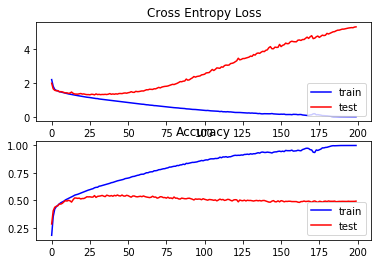

In [13]:
print("Parameter: {:,}".format(model_small.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_small['acc'][-1], history_small['val_acc'][-1]))
plot_summary(history_small)

(Interpreation...)

(Schwerer zu Erinnern, geht aber trotzdem, nicht so einfach anzugeben alles)

## Overfitting

In direkter Verbindung zu der Fähigkeit von DNN "auswendig" zu lernen steht das sogenannte Overfitting. Overfitting – Überanpassung – entsteht immer dann, wenn ein Modell zu sehr auf spezielle Trainingsdaten traniert wird und damit die generalisierungsleistung abnimmt. {@Explore overfitting and underfitting}
Nach herkömlicher Theorie entsteht eine Überanpassung, wenn ein Modell deutlich mehr Parameter hat als Trainingsdaten. Im Rahmen von DNN verhält sich dies etwas anders und die Gründe hierfür sind noch nicht ausreichend erforscht. {@A Closer Look at Memorization in Deep Networks}




- Statt generalisieren
- nicht erwünscht, da generalisierung abnimmt
- zu viele trainingsepisoden
- zu große kapazität

## Regularization

Eine weitere Methode um zu verhindern, dass DNNs die Daten auswendig lernen sind explizite Regularisierungstechniken. 

Hier kommen insbesondere 2 Verfahren in Betracht:
- Dropout: Beim Dropout wird ein Teil der Neuronen einer Schicht bei jedem Schritt des Trainings deaktiviert. 
- Batch Normalization

Zur Verdeutlichung der Funktionsweise von Regularisierung betrachten wir an dieser Stelle Dropout. Die Vorgehensweise ist leicht auf andere Regularisierungsverfahren übertragbar. 

Wir trainieren ein Modell mit Dropout-Schichten mit den _echten_ Labels und eins mit den _randomisierten_. 





### Regularization Normal

In [13]:
reg_params = dict(conv1_count=32, conv2_count=64, conv3_count=128, add_dropout=0.2, dense_count=512)
model_reg_normal, history_reg_normal = create_or_load_model('reg_normal', reg_params, lambda model: model.fit(trainX, trainY, epochs=100, batch_size=64, validation_data=(testX, testY)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
20096/50000 [===========>..................] - ETA: 5s - loss: 1.9511 - accuracy: 0.2961 ETA: 5s - loss: 1.9619 - accuracy: 

KeyboardInterrupt: 

Parameter: 1,341,226
Final Accuracy: 0.99442; Final Validation Accuracy: 0.7897


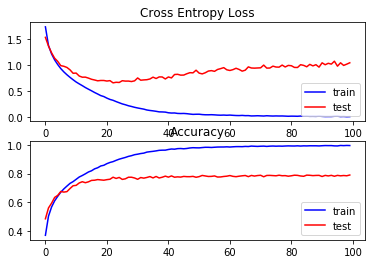

In [15]:
print("Parameter: {:,}".format(model_reg_normal.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_reg_normal['acc'][-1], history_reg_normal['val_acc'][-1]))
plot_summary(history_reg_normal)

### Regularization random

In [14]:
model_reg_random, history_reg_random = create_or_load_model('reg_random', reg_params, lambda model: model.fit(trainX, trainY_shuffle, epochs=100, batch_size=64, validation_data=(testX, testY)))

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
19456/50000 [==========>...................] - ETA: 5s - loss: 2.3286 - accuracy: 0.0987

KeyboardInterrupt: 

Parameter: 1,341,226
Final Accuracy: 0.61102; Final Validation Accuracy: 0.0937


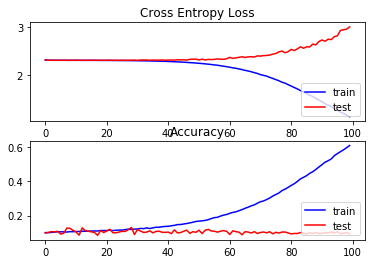

In [17]:
print("Parameter: {:,}".format(model_reg_random.count_params()))
print("Final Accuracy: {}; Final Validation Accuracy: {}".format(history_reg_random['acc'][-1], history_reg_random['val_acc'][-1]))
plot_summary(history_reg_random)

### Vergleich mit und ohne Dropout

#### Normale Trainingsdaten

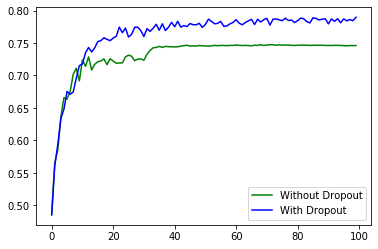

In [18]:
pyplot.plot(history_normal['val_acc'], color='green', label='Without Dropout')
pyplot.plot(history_reg_normal['val_acc'], color='blue', label='With Dropout')
pyplot.legend(loc='lower right')
pyplot.show()

#### Randomisierte Trainingsdaten

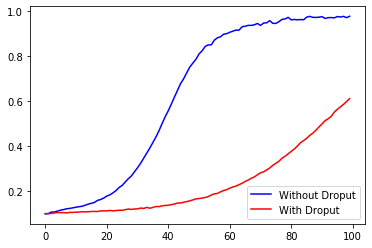

In [19]:
pyplot.plot(history_random['acc'], color='blue', label='Without Droput')
pyplot.plot(history_reg_random['acc'], color='red', label='With Droput')
pyplot.legend(loc='lower right')
pyplot.show()

Es wird schnell deutlich, dass das Modell mit Regularisierungsschichten die Daten deutlich langsamer lernt, als das Modell ohne Dropout und zusätzlich ist die Accuracy nach 100 Episoden nur bei knapp 75%. Im Kontext der Verhinderung von Overfitting ist dies das gewünschte Verhalten und ein Anhaltspunkt dafür, dass Dropout ein effektives Mittel gegen Overfitting ist.